In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


# Train and Test Transformation

In [ ]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2469, 0.2433, 0.2615))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2469, 0.2433, 0.2615))])

#Data Loader

In [ ]:
train = datasets.CIFAR10('./data',train = True, download = True, transform = train_transforms)
test = datasets.CIFAR10('./data',train = False, download = True, transform = test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 13049570.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
SEED = 1

cuda = torch.cuda.is_available()
print("Cuda Available?", cuda)

#For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Cuda Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Visualize Train Images

In [ ]:
import numpy as np
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_loader)
images,labels = next(dataiter)
images = images.numpy() #convert to numpy images

print(images.shape)
print(labels.shape)

(128, 3, 32, 32)
torch.Size([128])


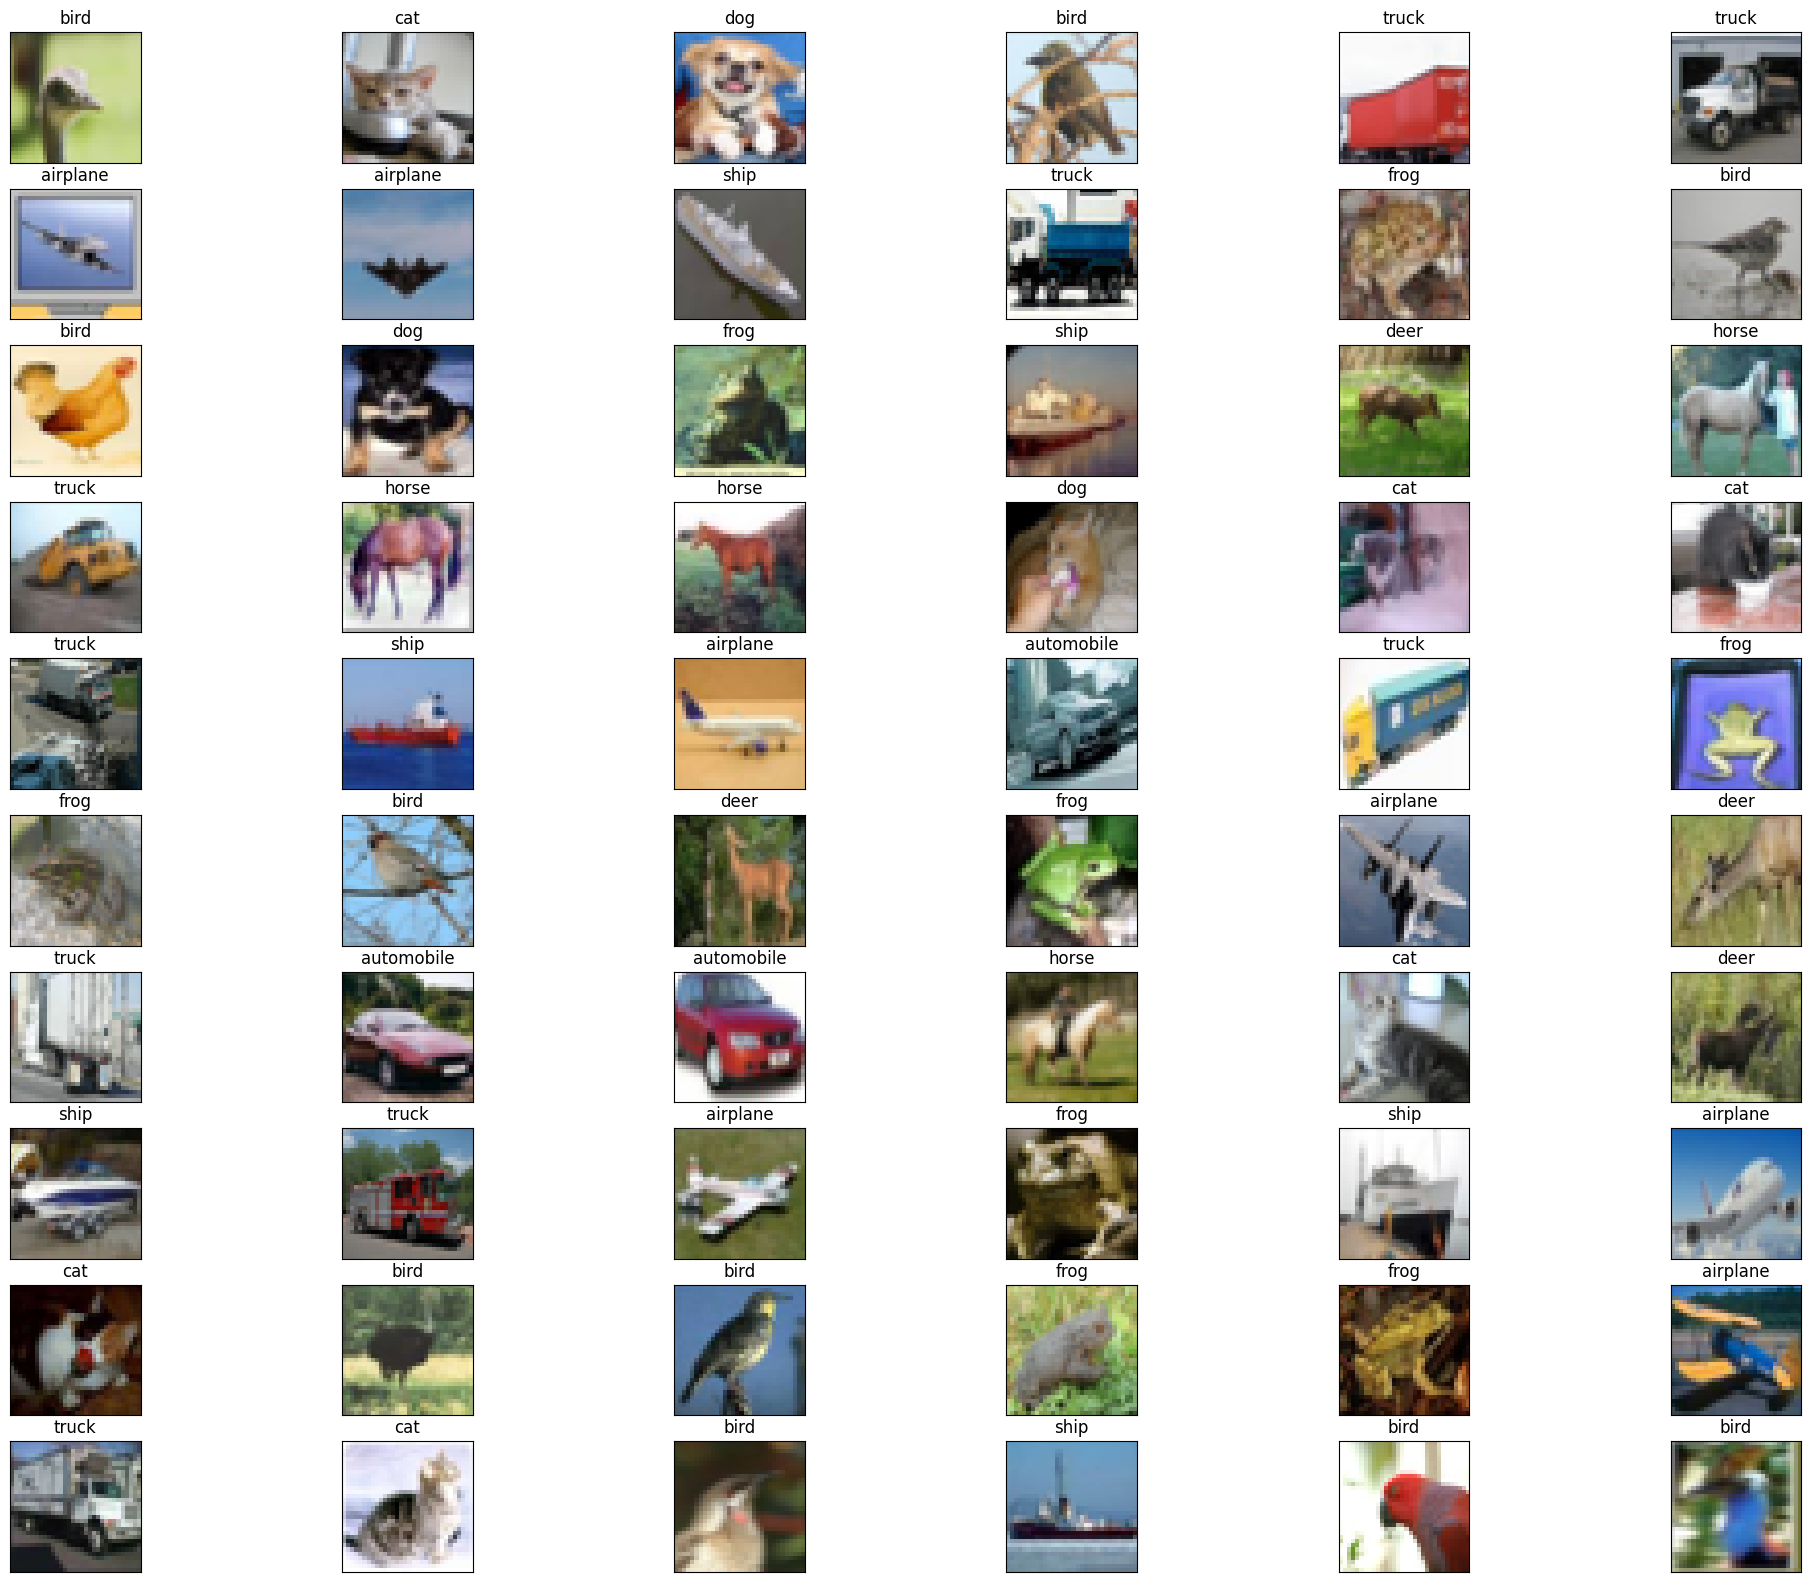

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
  channel_means = [0.4914, 0.4822, 0.4471]
  channel_std = [0.2469, 0.2433, 0.2615]

  for i in range(img.shape[0]):
    img[i]=(img[i]*channel_std[i])+channel_means[i]
    plt.imshow(np.transpose(img, (1,2,0)))

fig = plt.figure(figsize=(25,20))
for index in range(1,61):
  ax = fig.add_subplot(10, 6, index, xticks=[], yticks=[])
  imshow(images[index])
  ax.set_title(classes[labels[index]])


In [ ]:
from model_S8 import Net_BN, Net_LN, Net_GN
Normalization_Method = ['BN', 'LN', 'GN']
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cua else "cpu")
print(device)
for norm_method in Normalization_Method:
  if norm_method == 'BN':
    model = Net_BN().to(device)
    print(norm_method)
    summary(model, input_size=(3, 32, 32))
  elif norm_method == 'LN':
    model = Net_LN().to(device)
    print(norm_method)
    summary(model, input_size=(3, 32, 32))
  else:
    model = Net_GN().to(device)
    print(norm_method)
    summary(model, input_size=(3, 32, 32))



ModuleNotFoundError: No module named 'model_S8'

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

In [ ]:
t = [t_items.item() for t_items in train_losses]

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("BN: Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("BN: Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("BN: Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("BN: Test Accuracy")

#Evaluating Train and Test Accuracy

In [ ]:
import torch

def calAccuracy(net, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the  train images: {(100 * correct / total)} %%')

def calClassAccuracy(net, dataloader, classes, device):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))



In [ ]:
calAccuracy(model, train_loader, device)
calClassAccuracy(model, test_loader,classes, device)

#Plot Misclassified Images

In [ ]:
# import necessary libraries
import matplotlib.pyplot as plt
import torch
# from data_loader import unnormalize

# define a function to plot misclassified images
def plot_misclassified_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(npimg, cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()